In [28]:
import colorsys
import math
import os

import anndata
import distinctipy
import matplotlib
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn import preprocessing

In [2]:
save_folder = "../input/"

hbc_path = "../../Data/Embryo 1/hbc_mut_embryo1.txt"
mito_path = "../../Data/Embryo 1/mito_mut_embryo1_0.6.txt"
cell_map_type_path = "../../Data/Embryo 1/annotation_main_new3.csv"
rna_path = "../../Data/Embryo 1/concat.h5ad"

# pre process hbc mito

In [3]:
# input hbc and mito file formats
# cells * mutations

In [4]:
# hbc of embryo1
hbc = pd.read_csv(
    "../../Data/Embryo 1/hbc_mut_embryo1.txt", header=0, sep="\t", index_col=0
)
# regex = ".*-7938-3|.*-7995-1"
# hbc = hbc[hbc.index.str.match(regex)]

# remove mutations present only in <=1 cells. Remove cells which do not contain mutation
hbc = hbc.loc[:, hbc.sum() > 1]
hbc = hbc[hbc.sum(axis=1) > 0]
hbc.to_csv(save_folder + "hbc_mut.txt", sep="\t", index=True)

In [11]:
# mito of embyro1
mito = pd.read_csv(
    "../../Data/Embryo 1/mito_mut_embryo1_0.6.txt", header=0, sep="\t", index_col=0
)
# regex = ".*-7938-3|.*-7995-1"
# mito = mito[mito.index.str.match(regex)]

# remove mutations present only in <=1 cells. Remove cells which do not contain mutation
mito = mito.loc[:, mito.sum() > 1]
mito = mito[mito.sum(axis=1) > 0]

In [ ]:
# choose the threshold 0.6 for embryo1

(mito.sum() / mito.shape[0] * 100).sort_values().plot.bar(
    figsize=(20, 8),
    title="Mtio embryo1 mutions vs percentage of cells" + str(mito.shape),
    xlabel="mutaion name",
    ylabel="% of cells",
)

threshold = 0.6
mito_threshold = mito.loc[:, (mito.sum() / mito.shape[0] * 100) < threshold]
mito_threshold = mito_threshold.loc[mito_threshold.sum(axis=1) > 0, :]
mito_threshold

mito_threshold.to_csv(save_folder + "mito_mut.txt", sep="\t", index=True)

# RNA process

In [32]:
# process RNA as required for lintimat

In [7]:
adata = sc.read_h5ad(rna_path)
adata_sce = adata.copy()

In [4]:
import anndata2ri

anndata2ri.activate()
%load_ext rpy2.ipython

In [ ]:
%%R -i adata_sce -o X_imp -o cell_names -o gene_names
library(Seurat)
library(DrImpute)
library(SummarizedExperiment)

X <- assays(adata_sce)$X
cell_names = colnames(X)
X <- preprocessSC(X, min.expressed.gene = 0)
X.log <- log(X + 1)
set.seed(1)
X_imp <- DrImpute(X.log)

gene_names = rownames(X_imp)

/home/krushna/anaconda3/envs/tf1_dra/lib/python3.7/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
R[write to console]: Registered S3 method overwritten by 'spatstat.core':
  method          from
  formula.glmmPQL MASS

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp

R[write to console]: 
Attaching package: ‘Seurat’


R[write to console]: The following object is masked from ‘package:SummarizedExperiment’:

    Assays




----------------------------------------------------------------
Preprocess single cell RNA-seq expression matrix
----------------------------------------------------------------
number of input genes(nrow(X))=22228
number of input cells(ncol(X))=17337
number of input cells that express at least 0 genes=17337
number of input genes that are expressed in at least 2 cells and at most 100% cells=15689
sparsity of expression matrix=83.1%
Calculating Spearman distance. 


In [ ]:
adata = adata[list(cell_names), list(gene_names)]
adata.X = X_imp.T
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.write(save_folder + "concat_drimpute.h5ad")
adata

In [16]:
rna = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)
top_2000 = pd.DataFrame(rna.var().sort_values(ascending=False)[:2000].index)
top_2000.to_csv(save_folder + "top2000.txt", index=False, header=False)
top_2000

,Genes
0,Dab1
1,Gm12381
2,Osbpl2
3,Vmn1r69
4,Serpina1e
...,...
1995,Dtnb
1996,Lap3
1997,Rprd1b
1998,Sfxn1


# cell type color mapping

In [8]:
cell_map_type = pd.read_csv(cell_map_type_path, sep=",", index_col=0)
cell_types = sorted(list(set(cell_map_type["ClusterIdent"])))
print("number of cell types ", len(cell_types))

number of cell types  33


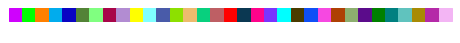

sorted colors


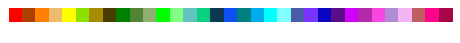

In [9]:
# ref https://www.alanzucconi.com/2015/09/30/colour-sorting/
colors = distinctipy.get_colors(len(cell_types), rng=0)
distinctipy.color_swatch(colors, one_row=True)
# sort the colors
def step(r, g, b, repetitions=1):
    lum = math.sqrt(0.241 * r + 0.691 * g + 0.068 * b)
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    h2 = int(h * repetitions)
    lum2 = int(lum * repetitions)
    v2 = int(v * repetitions)

    if h2 % 2 == 1:
        v2 = repetitions - v2
        lum = repetitions - lum

    return (h2, lum, v2)


colors.sort(key=lambda x: step(x[0], x[1], x[2], 8))
print("sorted colors")
distinctipy.color_swatch(colors, one_row=True)

cell_map_color = pd.DataFrame(
    list(zip(sorted(cell_types), colors)), columns=["cluster_type", "color"]
)
cell_map_color = cell_map_color.set_index("cluster_type")
cell_map_color["color"] = cell_map_color["color"].apply(matplotlib.colors.rgb2hex)
cell_map_color.color = cell_map_color.color.apply(lambda x: x.replace("#", ""))
pd.DataFrame(cell_map_color).reset_index().to_csv(
    save_folder + "celltype_map_color.txt", sep="\t", header=True, index=True
)

# Create Data for lintimat

In [13]:
hbc = pd.read_csv(save_folder + "hbc_mut.txt", sep="\t", index_col=0)
mito = pd.read_csv(save_folder + "mito_mut.txt", sep="\t", index_col=0)
hbc_mito = hbc.join(mito, how="outer").fillna(0)
print(hbc.shape, mito.shape, hbc_mito.shape)

cells = list(
    set(pd.read_csv(cell_map_type_path, sep=",", index_col=0).index)
    & set(hbc_mito.index)
)


mutations = hbc_mito.loc[cells]
mutations = mutations.loc[:, mutations.sum() > 1]
mutations = mutations.loc[mutations.sum(axis=1) > 0, :]

mutations = mutations.T
mutations = mutations.astype(int)
mutations = mutations.astype(str)

mutations

(1042, 270) (581, 197) (1564, 467)


row_0,GATCGGTACGAAGGTAAT-7995-1,ATTCCAGACCAGATTAC-7995-1,GTCTCTCTCTTACTCC-7938-3,ACTACTTGTAACTTAGC-7995-1,TTGGACTTCCGCAACT-7995-1,AAGCTATGAGGTGACAC-7995-1,AAAACGCCTCCGTGTTT-7938-3,CTATAGAGTCCTTATT-7995-1,GAGATTGCGAAGCTATGA-7995-1,GACCACATTAGTTGTCAT-7938-3,...,GCTCTAGTGGGTGTAT-7995-1,TGATAACCCGTCGGCTTAC-7995-1,GACGTACCTAATGCATGG-7995-1,ACAGGTGTCGGATAAAG-7995-1,AGCCAAGATCTTAGGTA-7995-1,TGATTGTCGCCGGGTTGGT-7938-3,AGCAGAACGCTTACCT-7995-1,GATGTACACGTGATAACA-7995-1,GACTTACTCCTCTGTGGT-7995-1,TGAAGGATTCAGCACCTCT-7995-1
BC10P12M-A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BC10P13D-GGTAGTCAT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BC10P18I-TC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BC10P21D-TG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BC10P24I-ACC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CybP8M-G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CybP9M-A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nd1P55I-T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nd3P25M-G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
rna_drimpute_path = save_folder + "concat_drimpute.h5ad"
adata_rna = sc.read_h5ad(rna_drimpute_path)
adata_rna = adata_rna[mutations.columns, :]
annotation = pd.read_csv(cell_map_type_path, sep=",", index_col=0).loc[
    adata_rna.obs_names
]

In [15]:
annotation.to_csv(save_folder + "annotations.txt", sep="\t")

In [16]:
le = preprocessing.LabelEncoder()
le.fit(list(mutations.index))
le_name_mapping = list(zip(le.classes_, le.transform(le.classes_)))
pd.DataFrame(le_name_mapping).to_csv(
    save_folder + "mutation_mapping.txt", sep="\t", header=False, index=False
)

In [17]:
for i in range(mutations.shape[0]):
    for j in range(mutations.shape[1]):
        if mutations.iloc[i][j] == "0":
            mutations.iloc[i][j] = "NONE"
        elif mutations.iloc[i][j] == "1":
            mutations.iloc[i][j] = le.transform([mutations.index[i]])[0]
        else:
            print(mutations.iloc[i][j], "error")

mutations

row_0,GATCGGTACGAAGGTAAT-7995-1,ATTCCAGACCAGATTAC-7995-1,GTCTCTCTCTTACTCC-7938-3,ACTACTTGTAACTTAGC-7995-1,TTGGACTTCCGCAACT-7995-1,AAGCTATGAGGTGACAC-7995-1,AAAACGCCTCCGTGTTT-7938-3,CTATAGAGTCCTTATT-7995-1,GAGATTGCGAAGCTATGA-7995-1,GACCACATTAGTTGTCAT-7938-3,...,GCTCTAGTGGGTGTAT-7995-1,TGATAACCCGTCGGCTTAC-7995-1,GACGTACCTAATGCATGG-7995-1,ACAGGTGTCGGATAAAG-7995-1,AGCCAAGATCTTAGGTA-7995-1,TGATTGTCGCCGGGTTGGT-7938-3,AGCAGAACGCTTACCT-7995-1,GATGTACACGTGATAACA-7995-1,GACTTACTCCTCTGTGGT-7995-1,TGAAGGATTCAGCACCTCT-7995-1
BC10P12M-A,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
BC10P13D-GGTAGTCAT,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
BC10P18I-TC,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
BC10P21D-TG,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
BC10P24I-ACC,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CybP8M-G,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
CybP9M-A,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
Nd1P55I-T,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
Nd3P25M-G,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [18]:
mutations = mutations.astype(str).apply("-".join, axis=0)
mutations = pd.DataFrame(mutations, columns=["HMID"])
mutations

,HMID
row_0,
GATCGGTACGAAGGTAAT-7995-1,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...
ATTCCAGACCAGATTAC-7995-1,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...
GTCTCTCTCTTACTCC-7938-3,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...
ACTACTTGTAACTTAGC-7995-1,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...
TTGGACTTCCGCAACT-7995-1,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...
...,...
TGATTGTCGCCGGGTTGGT-7938-3,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...
AGCAGAACGCTTACCT-7995-1,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...
GATGTACACGTGATAACA-7995-1,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...


In [19]:
mutations.to_csv(
    save_folder + "cell_mutation_mapping.txt", sep="\t", header=False, index=True
)

In [20]:
rna_data = pd.DataFrame(
    adata_rna.X, index=adata_rna.obs_names, columns=adata_rna.var_names
)
lintimat_format = pd.concat([annotation, mutations, rna_data], axis=1, join="inner")
clusters_to_numbers = pd.DataFrame(
    enumerate(lintimat_format["ClusterIdent"].astype("category").cat.categories)
)
lintimat_format["ClusterIdent"] = (
    lintimat_format["ClusterIdent"].astype("category").cat.codes
)
print(lintimat_format.shape)
lintimat_format.head()

(844, 15691)


,ClusterIdent,HMID,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009O20Rik,0610010F05Rik,0610011F06Rik,0610012G03Rik,0610025J13Rik,...,mt-Co1,mt-Co2,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5,mt-Nd6
GATCGGTACGAAGGTAAT-7995-1,11,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...,0.526589,0.135048,0.006232,0.039950,0.741276,0.111130,0.249403,0.002236,...,1.194705,0.211608,1.194705,1.587564,0.869742,0.959135,1.124748,0.058666,0.526589,0.741276
ATTCCAGACCAGATTAC-7995-1,24,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...,0.526589,0.136399,0.526589,0.042106,0.110441,0.112572,0.255880,0.002383,...,1.124748,0.220623,1.291725,1.439569,0.744534,0.526589,1.194705,0.058539,0.379392,0.741276
GTCTCTCTCTTACTCC-7938-3,13,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...,0.326344,0.133921,0.006821,0.033013,0.526589,0.115954,0.216164,0.001453,...,0.526589,0.190628,0.526589,0.741276,0.526589,0.438553,0.526589,0.059481,0.377552,0.526589
ACTACTTGTAACTTAGC-7995-1,26,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...,0.379841,0.155493,0.007728,0.041954,0.111203,0.128543,0.526589,0.001836,...,0.959135,0.264990,1.291725,1.124748,1.026672,0.459808,1.162283,0.058740,0.388058,0.741276
TTGGACTTCCGCAACT-7995-1,5,NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-NONE-N...,0.959135,0.526589,0.005609,0.040565,0.111028,0.113585,0.526589,0.002265,...,1.248441,0.223747,1.408800,1.466077,1.223156,0.741276,1.327761,0.060578,0.741276,0.959135


In [21]:
lintimat_format.to_csv(
    save_folder + "Data_matrix_Comb_final2_for_lintimat.txt", sep="\t"
)
clusters_to_numbers.to_csv(
    save_folder + "lintimat_cell_type_map.txt", sep="\t", index=False, header=False
)
lintimat_format.iloc[:, :2].to_csv(
    save_folder + "lintimat_txt_label_HMID.txt", sep="\t"
)

# run lintimat

In [24]:
# outputs in ../output folder

In [22]:
!date
!java -jar LinTIMaT.jar -i ../input/Data_matrix_Comb_final2_for_lintimat.txt \
 -gf ../input/top2000.txt \
  -gc 2000 \
   -ob ../output/bin_tree.newick \
    -on ../output/nonbinary_tree_lintimat.txt \
     -mi 400000 -ci 0 > ../output/terminal_output.txt
!date

Tue 29 Aug 04:42:50 IST 2023
Tue 29 Aug 04:44:19 IST 2023


In [23]:
print("done")

done


# Non binary & visualization

In [25]:
import visualize_tree
from ete3 import Tree

In [41]:
# tree_path binary-tree
cwd = os.getcwd() + "/"

cell_map_type_path = "../input/annotations.txt"
cell_type_map_color_path = "../input/celltype_map_color.txt"

cell_map_mutation_path = cwd + "../input/cell_mutation_mapping.txt"
mutation_map_names_path = cwd + "../input/mutation_mapping.txt"

tree_path = cwd + "../output/bin_tree.newick"

In [42]:
tree = Tree(tree_path, format=1)
tree, ts = visualize_tree.convert_to_non_binary(
    tree,
    cell_map_mutation_path,
    cell_map_type_path,
    cell_type_map_color_path,
    mutation_map_names_path,
    cwd,
)


tree.render(
    cwd + "../output/non_binary_ete3.pdf", w=10000, units="px", dpi=500, tree_style=ts
)
tree.write(format=1, outfile=cwd + "../output/non_binary_ete3.txt")
print("non binary tree saved to ", cwd + "../output/non_binary_ete3.pdf")
visualize_tree.del_pie_local(cwd + "../output/")

parsimony_score  799

parsimony score cal_score: 799
i2534
legend saved to :  /home/krushna/Documents/Lineage/Github/NSC-seq/single_cell_nonbinary_trees/src/lintimat/code/../output/legend.png


In [ ]:
tree.show(tree_style=ts)